#### Install python packages

In [1]:
!pip install PyDrive
!pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.7/dist-packages (2.4.3)


#### To access pre-trained embeddings and dataset (train and test)

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:

download = drive.CreateFile({'id':'1gVExcJs31_mHWFGNvH3YpXBnS-A_XurA'})   # replace the id with id of file you want to access
download.GetContentFile('train.csv')        # replace the file name with your file

download = drive.CreateFile({'id':'13Nc1ZZaJD7_kBup22ScZYXmxAYNg1TOT'})   # replace the id with id of file you want to access
download.GetContentFile('test.csv')        # replace the file name with your file

download = drive.CreateFile({'id':'1xyw2FyO1RTOAK-h7V3PYF_Sxmn8ho5jh'})   # replace the id with id of file you want to access
download.GetContentFile('gold_test.csv')        # replace the file name with your file


In [17]:

downloaded = drive.CreateFile({'id':'1GH7dGh9ftQikz8KIDedxBooBzX_qw0zW'})   # replace the id with id of file you want to access
downloaded.GetContentFile('glove.6B.100d.txt')        # replace the file name with your file

download = drive.CreateFile({'id':'1daXpP2rI4YDUHwl4I-kDolS9JfoTY_r4'})   # replace the id with id of file you want to access
download.GetContentFile('glove.6B.200d.txt')        # replace the file name with your file

download = drive.CreateFile({'id':'15IB-nj1e-E6B9PRpJslkB1RMBEtiCA6l'})   # replace the id with id of file you want to access
download.GetContentFile('glove.6B.300d.txt')        # replace the file name with your file

download = drive.CreateFile({'id':'1rH_EvmtKprvULcKj5ARNI3r3p6K9EGwO'})   # replace the id with id of file you want to access
download.GetContentFile('wiki-news-300d-1M.vec')        # replace the file name with your file

download = drive.CreateFile({'id':'1mPXuUDiPAPid2nGjnhUQIzn8Qz-nHp6V'})   # replace the id with id of file you want to access
download.GetContentFile('GoogleNews-vectors-negative300.bin')        # replace the file name with your file

#### Header files

In [5]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, SimpleRNN, LSTM, Bidirectional, GRU
from sklearn import datasets, model_selection, metrics
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split 
nltk.download('stopwords')
stopword = stopwords.words('english') 
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#### Preprocessing function

In [6]:
def encode_data(tokenizer, text, tokens, preprocessing_training_data = False):
    # This function will be used to encode the reviews using a dictionary (created using corpus vocabulary) 

    # Example of encoding :"The food was fabulous but pricey" has a vocabulary of 4 words, each one has to be mapped to an integer like: 
    # {'The':1,'food':2,'was':3 'fabulous':4 'but':5 'pricey':6} this vocabulary has to be created for the entire corpus and then be used to 
    # encode the words into integers 

    # return encoded examples
    if preprocessing_training_data:
        tokenizer = Tokenizer(oov_token = '<oov>')
        tokenizer.fit_on_texts(tokens)

    sequences = tokenizer.texts_to_sequences(text)
    return sequences, tokenizer

def convert_to_lower(text):
    # return the reviews after convering then to lowercase
    lower_text = text.lower()
    return lower_text

def perform_tokenization(text):
    # return the reviews after performing tokenization
    token=nltk.word_tokenize(text)
    return token

def remove_stopwords(text):
    # return the reviews after removing the stopwords
    stopword = [] # not any stopword
    removing_stopwords=[word for word in text if word not in stopword]
    return removing_stopwords

def remove_punctuation(text):
    # return the reviews after removing punctuations
    removing_punctuation = [word for word in text if word.isalpha()]
    return removing_punctuation

def perform_padding(data, maxlen):
    # return the reviews after padding the reviews to maximum length
    padded_data = pad_sequences(data, maxlen=maxlen, padding='post')
    return padded_data

def preprocess_data(tokenizer, data, preprocessing_training_data=False, maxlen=None):
    # make all the following function calls on your data
    # EXAMPLE:->
    '''
    review = data["reviews"]
    review = convert_to_lower(review)
    review = remove_punctuation(review)
    review = remove_stopwords(review)
    review = perform_tokenization(review)
    review = encode_data(review)
    review = perform_padding(review)
    '''
    # return processed data

    reviews = data["reviews"]
    list_of_reviews = list(reviews)
    string_of_reviews = ' '.join(str(e) for e in list_of_reviews)

    lower_text = convert_to_lower(string_of_reviews)
    tokens = perform_tokenization(lower_text)
    tokens = remove_stopwords(tokens)
    tokens = remove_punctuation(tokens)
    encoded_data, tokenizer = encode_data(tokenizer, reviews, tokens, preprocessing_training_data)
    reviews = perform_padding(encoded_data, maxlen)

    return pd.DataFrame(reviews), tokenizer

### Define Models (with pre-trained embedding layer)

#### Feed Forward Neural Network 

In [7]:
def softmax_activation(x):
    # write your own implementation from scratch and return softmax values(using predefined softmax is prohibited)
    Exponent_calculation=tf.exp(x-tf.reduce_max(x,axis=-1,keepdims=True))
    Normalization=tf.reduce_sum(Exponent_calculation,axis=-1,keepdims=True)
    return Exponent_calculation/Normalization
    

class NeuralNet:

    def __init__(self, reviews, ratings,e):
        self.reviews = reviews
        self.ratings = ratings
        self.e = e
    def build_nn(self):
        #add the input and output layer here; you can use either tensorflow or pytorch
        self.model = Sequential()
        print("Reviews Shape: ", self.reviews.shape)
        print("Ratings Shape: ", self.ratings.shape)
        self.model.add(e)
        self.model.add(Flatten())
        #self.model.add(Dense(5  , activation="relu" ))
        #self.model.add(Dense(32, activation='sigmoid'))
        self.model.add(Dense(5))
        self.model.add(Activation(softmax_activation, name='Softmax'))

        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
       
    def train_nn(self,batch_size,epochs, ):
        # write the training loop here; you can use either tensorflow or pytorch
        # print validation accuracy
        self.model.fit(self.reviews, self.ratings, epochs=epochs, batch_size=batch_size, verbose=1)

    def predict(self, reviews):
        # return a list containing all the ratings predicted by the trained model
        predicted = self.model.predict(reviews)
        return predicted

#### LSTM

In [8]:
def softmax_activation(x):
    # write your own implementation from scratch and return softmax values(using predefined softmax is prohibited)
    Exponent_calculation=tf.exp(x-tf.reduce_max(x,axis=-1,keepdims=True))
    Normalization=tf.reduce_sum(Exponent_calculation,axis=-1,keepdims=True)
    return Exponent_calculation/Normalization
    
    
class LSTMNet:

    def __init__(self, reviews, ratings, e):
        self.reviews = reviews
        self.ratings = ratings
        self.e = e
    def build_nn(self):
        #add the input and output layer here; you can use either tensorflow or pytorch
        self.model = Sequential()
        print("Reviews Shape: ", self.reviews.shape)
        print("Ratings Shape: ", self.ratings.shape)
        self.model.add(self.e)
        # self.model.add(Flatten())
        self.model.add(LSTM(128))
        #self.model.add(Dense(5  , activation="relu" ))
        #self.model.add(Dense(32, activation='sigmoid'))
        self.model.add(Dense(5))
        self.model.add(Activation(softmax_activation, name='Softmax'))

        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
       
    def train_nn(self,batch_size,epochs, ):
        # write the training loop here; you can use either tensorflow or pytorch
        # print validation accuracy
        self.model.fit(self.reviews, self.ratings, epochs=epochs, batch_size=batch_size, verbose=1)

    def predict(self, reviews):
        # return a list containing all the ratings predicted by the trained model
        predicted = self.model.predict(reviews)
        return predicted

#### Bi-LSTM

In [9]:
def softmax_activation(x):
    # write your own implementation from scratch and return softmax values(using predefined softmax is prohibited)
    Exponent_calculation=tf.exp(x-tf.reduce_max(x,axis=-1,keepdims=True))
    Normalization=tf.reduce_sum(Exponent_calculation,axis=-1,keepdims=True)
    return Exponent_calculation/Normalization
    
    
class BiLSTMNet:

    def __init__(self, reviews, ratings, e):
        self.reviews = reviews
        self.ratings = ratings
        self.e = e
    def build_nn(self):
        #add the input and output layer here; you can use either tensorflow or pytorch
        self.model = Sequential()
        print("Reviews Shape: ", self.reviews.shape)
        print("Ratings Shape: ", self.ratings.shape)
        self.model.add(self.e)
        # self.model.add(Flatten())
        self.model.add(Bidirectional(LSTM(128)))
        #self.model.add(Dense(5  , activation="relu" ))
        #self.model.add(Dense(32, activation='sigmoid'))
        self.model.add(Dense(5))
        self.model.add(Activation(softmax_activation, name='Softmax'))

        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
       
    def train_nn(self,batch_size,epochs, ):
        # write the training loop here; you can use either tensorflow or pytorch
        # print validation accuracy
        self.model.fit(self.reviews, self.ratings, epochs=epochs, batch_size=batch_size, verbose=1)

    def predict(self, reviews):
        # return a list containing all the ratings predicted by the trained model
        predicted = self.model.predict(reviews)
        return predicted

#### GRU

In [10]:
def softmax_activation(x):
    # write your own implementation from scratch and return softmax values(using predefined softmax is prohibited)
    Exponent_calculation=tf.exp(x-tf.reduce_max(x,axis=-1,keepdims=True))
    Normalization=tf.reduce_sum(Exponent_calculation,axis=-1,keepdims=True)
    return Exponent_calculation/Normalization
    
    
class GRUmodel:

    def __init__(self, reviews, ratings, e):
        self.reviews = reviews
        self.ratings = ratings
        self.e = e
    def build_nn(self):
        #add the input and output layer here; you can use either tensorflow or pytorch
        self.model = Sequential()
        print("Reviews Shape: ", self.reviews.shape)
        print("Ratings Shape: ", self.ratings.shape)
        self.model.add(self.e)
        # self.model.add(Flatten())
        self.model.add(GRU(128))
        #self.model.add(Dense(5 , activation="relu" ))
        #self.model.add(Dense(32 , activation='sigmoid'))
        self.model.add(Dense(5))
        self.model.add(Activation(softmax_activation, name='Softmax'))

        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
       
    def train_nn(self,batch_size,epochs, ):
        # write the training loop here; you can use either tensorflow or pytorch
        # print validation accuracy
        self.model.fit(self.reviews, self.ratings, epochs=epochs, batch_size=batch_size, verbose=1)

    def predict(self, reviews):
        # return a list containing all the ratings predicted by the trained model
        predicted = self.model.predict(reviews)
        return predicted

#### Bi-GRU

In [11]:
def softmax_activation(x):
    # write your own implementation from scratch and return softmax values(using predefined softmax is prohibited)
    Exponent_calculation=tf.exp(x-tf.reduce_max(x,axis=-1,keepdims=True))
    Normalization=tf.reduce_sum(Exponent_calculation,axis=-1,keepdims=True)
    return Exponent_calculation/Normalization
    
    
class BiGRUmodel:

    def __init__(self, reviews, ratings, e):
        self.reviews = reviews
        self.ratings = ratings
        self.e = e
    def build_nn(self):
        #add the input and output layer here; you can use either tensorflow or pytorch
        self.model = Sequential()
        print("Reviews Shape: ", self.reviews.shape)
        print("Ratings Shape: ", self.ratings.shape)
        self.model.add(self.e)
        # self.model.add(Flatten())
        self.model.add(Bidirectional(GRU(128)))
        #self.model.add(Dense(5 , activation="relu" ))
        #self.model.add(Dense(32 , activation='sigmoid'))
        self.model.add(Dense(5))
        self.model.add(Activation(softmax_activation, name='Softmax'))

        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
       
    def train_nn(self,batch_size,epochs, ):
        # write the training loop here; you can use either tensorflow or pytorch
        # print validation accuracy
        self.model.fit(self.reviews, self.ratings, epochs=epochs, batch_size=batch_size, verbose=1)

    def predict(self, reviews):
        # return a list containing all the ratings predicted by the trained model
        predicted = self.model.predict(reviews)
        return predicted

#### RNN

In [12]:
def softmax_activation(x):
    # write your own implementation from scratch and return softmax values(using predefined softmax is prohibited)
    Exponent_calculation=tf.exp(x-tf.reduce_max(x,axis=-1,keepdims=True))
    Normalization=tf.reduce_sum(Exponent_calculation,axis=-1,keepdims=True)
    return Exponent_calculation/Normalization
    
    
class RNNNet:

    def __init__(self, reviews, ratings, e):
        self.reviews = reviews
        self.ratings = ratings
        self.e = e
    def build_nn(self):
        #add the input and output layer here; you can use either tensorflow or pytorch
        self.model = Sequential()
        print("Reviews Shape: ", self.reviews.shape)
        print("Ratings Shape: ", self.ratings.shape)
        self.model.add(self.e)
        # self.model.add(Flatten())
        self.model.add(SimpleRNN(128))
        #self.model.add(Dense(5  , activation="relu" ))
        #self.model.add(Dense(32, activation='sigmoid'))
        self.model.add(Dense(5))
        self.model.add(Activation(softmax_activation, name='Softmax'))

        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
       
    def train_nn(self,batch_size,epochs, ):
        # write the training loop here; you can use either tensorflow or pytorch
        # print validation accuracy
        self.model.fit(self.reviews, self.ratings, epochs=epochs, batch_size=batch_size, verbose=1)

    def predict(self, reviews):
        # return a list containing all the ratings predicted by the trained model
        predicted = self.model.predict(reviews)
        return predicted

### Define Models (without pre-trained embedding layer)

#### Feed Forward Neural Network 

In [ ]:
def softmax_activation(x):
    # write your own implementation from scratch and return softmax values(using predefined softmax is prohibited)
    Exponent_calculation=tf.exp(x-tf.reduce_max(x,axis=-1,keepdims=True))
    Normalization=tf.reduce_sum(Exponent_calculation,axis=-1,keepdims=True)
    return Exponent_calculation/Normalization
    

class NeuralNet:

    def __init__(self, reviews, ratings,e):
        self.reviews = reviews
        self.ratings = ratings
        self.e = e
    def build_nn(self):
        #add the input and output layer here; you can use either tensorflow or pytorch
        self.model = Sequential()
        print("Reviews Shape: ", self.reviews.shape)
        print("Ratings Shape: ", self.ratings.shape)
        self.model.add(Embedding(vocab_size, 300, input_length=maxlen, trainable=True))
        self.model.add(Flatten())
        #self.model.add(Dense(5  , activation="relu" ))
        #self.model.add(Dense(32, activation='sigmoid'))
        self.model.add(Dense(5))
        self.model.add(Activation(softmax_activation, name='Softmax'))

        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
       
    def train_nn(self,batch_size,epochs, ):
        # write the training loop here; you can use either tensorflow or pytorch
        # print validation accuracy
        self.model.fit(self.reviews, self.ratings, epochs=epochs, batch_size=batch_size, verbose=1)

    def predict(self, reviews):
        # return a list containing all the ratings predicted by the trained model
        predicted = self.model.predict(reviews)
        return predicted

#### LSTM

In [ ]:
def softmax_activation(x):
    # write your own implementation from scratch and return softmax values(using predefined softmax is prohibited)
    Exponent_calculation=tf.exp(x-tf.reduce_max(x,axis=-1,keepdims=True))
    Normalization=tf.reduce_sum(Exponent_calculation,axis=-1,keepdims=True)
    return Exponent_calculation/Normalization
    
    
class LSTMNet:

    def __init__(self, reviews, ratings, e):
        self.reviews = reviews
        self.ratings = ratings
        self.e = e
    def build_nn(self):
        #add the input and output layer here; you can use either tensorflow or pytorch
        self.model = Sequential()
        print("Reviews Shape: ", self.reviews.shape)
        print("Ratings Shape: ", self.ratings.shape)
        self.model.add(Embedding(vocab_size, 300, input_length=maxlen, trainable=True))
        # self.model.add(Flatten())
        self.model.add(LSTM(128))
        #self.model.add(Dense(5  , activation="relu" ))
        #self.model.add(Dense(32, activation='sigmoid'))
        self.model.add(Dense(5))
        self.model.add(Activation(softmax_activation, name='Softmax'))

        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
       
    def train_nn(self,batch_size,epochs, ):
        # write the training loop here; you can use either tensorflow or pytorch
        # print validation accuracy
        self.model.fit(self.reviews, self.ratings, epochs=epochs, batch_size=batch_size, verbose=1)

    def predict(self, reviews):
        # return a list containing all the ratings predicted by the trained model
        predicted = self.model.predict(reviews)
        return predicted

#### Bi-LSTM

In [ ]:
def softmax_activation(x):
    # write your own implementation from scratch and return softmax values(using predefined softmax is prohibited)
    Exponent_calculation=tf.exp(x-tf.reduce_max(x,axis=-1,keepdims=True))
    Normalization=tf.reduce_sum(Exponent_calculation,axis=-1,keepdims=True)
    return Exponent_calculation/Normalization
    
    
class BiLSTMNet:

    def __init__(self, reviews, ratings, e):
        self.reviews = reviews
        self.ratings = ratings
        self.e = e
    def build_nn(self):
        #add the input and output layer here; you can use either tensorflow or pytorch
        self.model = Sequential()
        print("Reviews Shape: ", self.reviews.shape)
        print("Ratings Shape: ", self.ratings.shape)
        self.model.add(Embedding(vocab_size, 300, input_length=maxlen, trainable=True))
        # self.model.add(Flatten())
        self.model.add(Bidirectional(LSTM(128)))
        #self.model.add(Dense(5  , activation="relu" ))
        #self.model.add(Dense(32, activation='sigmoid'))
        self.model.add(Dense(5))
        self.model.add(Activation(softmax_activation, name='Softmax'))

        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
       
    def train_nn(self,batch_size,epochs, ):
        # write the training loop here; you can use either tensorflow or pytorch
        # print validation accuracy
        self.model.fit(self.reviews, self.ratings, epochs=epochs, batch_size=batch_size, verbose=1)

    def predict(self, reviews):
        # return a list containing all the ratings predicted by the trained model
        predicted = self.model.predict(reviews)
        return predicted

#### GRU

In [ ]:
def softmax_activation(x):
    # write your own implementation from scratch and return softmax values(using predefined softmax is prohibited)
    Exponent_calculation=tf.exp(x-tf.reduce_max(x,axis=-1,keepdims=True))
    Normalization=tf.reduce_sum(Exponent_calculation,axis=-1,keepdims=True)
    return Exponent_calculation/Normalization
    
    
class GRUmodel:

    def __init__(self, reviews, ratings, e):
        self.reviews = reviews
        self.ratings = ratings
        self.e = e
    def build_nn(self):
        #add the input and output layer here; you can use either tensorflow or pytorch
        self.model = Sequential()
        print("Reviews Shape: ", self.reviews.shape)
        print("Ratings Shape: ", self.ratings.shape)
        self.model.add(Embedding(vocab_size, 300, input_length=maxlen, trainable=True))
        # self.model.add(Flatten())
        self.model.add(GRU(128))
        #self.model.add(Dense(5 , activation="relu" ))
        #self.model.add(Dense(32 , activation='sigmoid'))
        self.model.add(Dense(5))
        self.model.add(Activation(softmax_activation, name='Softmax'))

        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
       
    def train_nn(self,batch_size,epochs, ):
        # write the training loop here; you can use either tensorflow or pytorch
        # print validation accuracy
        self.model.fit(self.reviews, self.ratings, epochs=epochs, batch_size=batch_size, verbose=1)

    def predict(self, reviews):
        # return a list containing all the ratings predicted by the trained model
        predicted = self.model.predict(reviews)
        return predicted

#### Bi-GRU

In [ ]:
def softmax_activation(x):
    # write your own implementation from scratch and return softmax values(using predefined softmax is prohibited)
    Exponent_calculation=tf.exp(x-tf.reduce_max(x,axis=-1,keepdims=True))
    Normalization=tf.reduce_sum(Exponent_calculation,axis=-1,keepdims=True)
    return Exponent_calculation/Normalization
    
    
class BiGRUmodel:

    def __init__(self, reviews, ratings, e):
        self.reviews = reviews
        self.ratings = ratings
        self.e = e
    def build_nn(self):
        #add the input and output layer here; you can use either tensorflow or pytorch
        self.model = Sequential()
        print("Reviews Shape: ", self.reviews.shape)
        print("Ratings Shape: ", self.ratings.shape)
        self.model.add(Embedding(vocab_size, 300, input_length=maxlen, trainable=True))
        # self.model.add(Flatten())
        self.model.add(Bidirectional(GRU(128)))
        #self.model.add(Dense(5 , activation="relu" ))
        #self.model.add(Dense(32 , activation='sigmoid'))
        self.model.add(Dense(5))
        self.model.add(Activation(softmax_activation, name='Softmax'))

        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
       
    def train_nn(self,batch_size,epochs, ):
        # write the training loop here; you can use either tensorflow or pytorch
        # print validation accuracy
        self.model.fit(self.reviews, self.ratings, epochs=epochs, batch_size=batch_size, verbose=1)

    def predict(self, reviews):
        # return a list containing all the ratings predicted by the trained model
        predicted = self.model.predict(reviews)
        return predicted

#### RNN

In [ ]:
def softmax_activation(x):
    # write your own implementation from scratch and return softmax values(using predefined softmax is prohibited)
    Exponent_calculation=tf.exp(x-tf.reduce_max(x,axis=-1,keepdims=True))
    Normalization=tf.reduce_sum(Exponent_calculation,axis=-1,keepdims=True)
    return Exponent_calculation/Normalization
    
    
class RNNNet:

    def __init__(self, reviews, ratings, e):
        self.reviews = reviews
        self.ratings = ratings
        self.e = e
    def build_nn(self):
        #add the input and output layer here; you can use either tensorflow or pytorch
        self.model = Sequential()
        print("Reviews Shape: ", self.reviews.shape)
        print("Ratings Shape: ", self.ratings.shape)
        self.model.add(Embedding(vocab_size, 300, input_length=maxlen, trainable=True))
        # self.model.add(Flatten())
        self.model.add(SimpleRNN(128))
        #self.model.add(Dense(5  , activation="relu" ))
        #self.model.add(Dense(32, activation='sigmoid'))
        self.model.add(Dense(5))
        self.model.add(Activation(softmax_activation, name='Softmax'))

        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
       
    def train_nn(self,batch_size,epochs, ):
        # write the training loop here; you can use either tensorflow or pytorch
        # print validation accuracy
        self.model.fit(self.reviews, self.ratings, epochs=epochs, batch_size=batch_size, verbose=1)

    def predict(self, reviews):
        # return a list containing all the ratings predicted by the trained model
        predicted = self.model.predict(reviews)
        return predicted

### Import Datasets

In [18]:
# reading dataset
train_data = pd.read_csv("train.csv", index_col=0)
test_data = pd.read_csv("test.csv", index_col=0)

# separate reviews, ratings
train_reviews = train_data.iloc[:, :-1]
train_ratings = train_data.iloc[:, -1]
train_ratings = pd.get_dummies(train_ratings)
   
tokenizer = Tokenizer(oov_token = '<oov>')

# pre-process data
train_reviews, tokenizer = preprocess_data(tokenizer, train_data, preprocessing_training_data=True)
test_reviews, tokenizer = preprocess_data(tokenizer, test_data, maxlen=train_reviews.shape[1])
print(len(train_reviews))
print(len(train_ratings))
maxlen=train_reviews.shape[1]
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

50000
50000
15956


### Word Embeddings

#### Glove

In [ ]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(train_reviews.shape)
print(embedding_matrix.shape)
e = Embedding(vocab_size, 300, embeddings_initializer=Constant(embedding_matrix), input_length=maxlen, trainable=False)
# TODO: Cross-validate
print(train_reviews.shape)

FileNotFoundError: ignored

#### Fasttext


In [ ]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('wiki-news-300d-1M.vec')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
#print(values)
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
     embedding_vector = embeddings_index.get(word)
     if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(train_reviews.shape)
print(embedding_matrix.shape)
e = Embedding(vocab_size, 300, embeddings_initializer=Constant(embedding_matrix), input_length=maxlen, trainable=True)
# TODO: Cross-validate
print(train_reviews.shape)

Loaded 999995 word vectors.
(50000, 31)
(15956, 300)
(50000, 31)


####Word2vec

In [19]:
from gensim.models import KeyedVectors

# load the whole embedding into memory
embeddings_index = dict()


#f = open('GoogleNews-vectors-negative300.bin')
model_w2v = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
print(type(model_w2v))


<class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>


In [20]:
# prepare embedding matrix
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    if word in model_w2v.vocab:
        embedding_vector = model_w2v[word]
        embedding_vector = np.array(embedding_vector)
        if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector

e = Embedding(vocab_size, 300, embeddings_initializer=Constant(embedding_matrix), input_length=maxlen, trainable=False)

### Without pre-trained word embedding

In [ ]:
e = None

### Data Imbalanced Handling


#### Utility Functions

In [ ]:
def class_counts(ratings):    
    # find # of elements of each class
    cnts = ratings.value_counts()
    class1_count = cnts[1]
    class2_count = cnts[2]
    class3_count = cnts[3]
    class4_count = cnts[4]
    class5_count = cnts[5]
    
    return class1_count, class2_count, class3_count, class4_count, class5_count

def minority_class_count(ratings):
    # find # no of elements in the minority class
    return min(class_counts(ratings))

def majority_class_count(ratings):
    # find # no of elements in the minority class
    return max(class_counts(ratings))

def average_class_count(ratings):
    return int(sum(class_counts(ratings))/5) 


####  Undersampling Technique-1

In [ ]:
# 1. reduce the number of ratings of each class to the 'minority_class_count' 
class1_data = train_data[train_data['ratings']==1]
class2_data = train_data[train_data['ratings']==2]
class3_data = train_data[train_data['ratings']==3]
class4_data = train_data[train_data['ratings']==4]
class5_data = train_data[train_data['ratings']==5]

minority_class_cnt = minority_class_count(train_data['ratings'])
class1_data = class1_data.sample(minority_class_cnt, random_state=1)
class2_data = class2_data.sample(minority_class_cnt, random_state=1)
class3_data = class3_data.sample(minority_class_cnt, random_state=1)
class4_data = class4_data.sample(minority_class_cnt, random_state=1)
class5_data = class5_data.sample(minority_class_cnt, random_state=1)

train_data_undersample = pd.concat([class1_data, class2_data, class3_data, class4_data, class5_data], axis=0)

# separate reviews, ratings
train_reviews = train_data_undersample.iloc[:, :-1]
train_ratings = train_data_undersample.iloc[:, -1]
train_ratings = pd.get_dummies(train_ratings)
   
tokenizer = Tokenizer(oov_token = '<oov>')

# pre-process data
train_reviews, tokenizer = preprocess_data(tokenizer, train_data_undersample, preprocessing_training_data=True)
test_reviews, tokenizer = preprocess_data(tokenizer, test_data, maxlen=train_reviews.shape[1])

maxlen=train_reviews.shape[1]
vocab_size = len(tokenizer.word_index) + 1

print("Vocab Size:", vocab_size)
print("Train Data Shape:", train_reviews.shape, "Test Data Shape:", test_reviews.shape)
print(f"Train Data Distribution:\n{train_data_undersample['ratings'].value_counts()}")

Vocab Size: 8243
Train Data Shape: (11325, 30) Test Data Shape: (10000, 30)
Train Data Distribution:
5    2265
4    2265
3    2265
2    2265
1    2265
Name: ratings, dtype: int64


#### Undersampling technique-2

In [ ]:
# 2. reduce the number of ratings of each class to the 'avg_class_count' 
class1_data = train_data[train_data['ratings']==1]
class2_data = train_data[train_data['ratings']==2]
class3_data = train_data[train_data['ratings']==3]
class4_data = train_data[train_data['ratings']==4]
class5_data = train_data[train_data['ratings']==5]

avg_class_count = average_class_count(train_data['ratings'])
class1_data = class1_data.sample(min(class1_data.shape[0], avg_class_count), random_state=1)
class2_data = class2_data.sample(min(class2_data.shape[0], avg_class_count), random_state=1)
class3_data = class3_data.sample(min(class3_data.shape[0], avg_class_count), random_state=1)
class4_data = class4_data.sample(min(class4_data.shape[0], avg_class_count), random_state=1)
class5_data = class5_data.sample(min(class5_data.shape[0], avg_class_count), random_state=1)

train_data_undersample = pd.concat([class1_data, class2_data, class3_data, class4_data, class5_data], axis=0)

# separate reviews, ratings
train_reviews = train_data_undersample.iloc[:, :-1]
train_ratings = train_data_undersample.iloc[:, -1]
train_ratings = pd.get_dummies(train_ratings)
   
tokenizer = Tokenizer(oov_token = '<oov>')

# pre-process data
train_reviews, tokenizer = preprocess_data(tokenizer, train_data_undersample, preprocessing_training_data=True)
test_reviews, tokenizer = preprocess_data(tokenizer, test_data, maxlen=train_reviews.shape[1])

maxlen=train_reviews.shape[1]
vocab_size = len(tokenizer.word_index) + 1

print("Vocab Size:", vocab_size)
print("Train Data Shape:", train_reviews.shape, "Test Data Shape:", test_reviews.shape)
print(f"Train Data Distribution:\n{train_data_undersample['ratings'].value_counts()}")

Vocab Size: 12294
Train Data Shape: (26807, 31) Test Data Shape: (10000, 31)
Train Data Distribution:
5    10000
4     6871
1     4059
3     3612
2     2265
Name: ratings, dtype: int64


#### Oversampling Technique-1


In [ ]:
# 1. increase the number of ratings of each class to the 'majority_class_count' 
class1_data = train_data[train_data['ratings']==1]
class2_data = train_data[train_data['ratings']==2]
class3_data = train_data[train_data['ratings']==3]
class4_data = train_data[train_data['ratings']==4]
class5_data = train_data[train_data['ratings']==5]

majority_class_cnt = majority_class_count(train_data['ratings'])
class1_data = class1_data.sample(majority_class_cnt, random_state=1, replace=True)
class2_data = class2_data.sample(majority_class_cnt, random_state=1, replace=True)
class3_data = class3_data.sample(majority_class_cnt, random_state=1, replace=True)
class4_data = class4_data.sample(majority_class_cnt, random_state=1, replace=True)
class5_data = class5_data.sample(majority_class_cnt, random_state=1, replace=True)

train_data_oversample = pd.concat([class1_data, class2_data, class3_data, class4_data, class5_data], axis=0)

# separate reviews, ratings
train_reviews = train_data_undersample.iloc[:, :-1]
train_ratings = train_data_undersample.iloc[:, -1]
train_ratings = pd.get_dummies(train_ratings)
   
tokenizer = Tokenizer(oov_token = '<oov>')

# pre-process data
train_reviews, tokenizer = preprocess_data(tokenizer, train_data_oversample, preprocessing_training_data=True)
test_reviews, tokenizer = preprocess_data(tokenizer, test_data, maxlen=train_reviews.shape[1])

maxlen=train_reviews.shape[1]
vocab_size = len(tokenizer.word_index) + 1

print("Vocab Size:", vocab_size)
print("Train Data Shape:", train_reviews.shape, "Test Data Shape:", test_reviews.shape)
print(f"Train Data Distribution:\n{train_data_oversample['ratings'].value_counts()}")

Vocab Size: 14210
Train Data Shape: (165965, 31) Test Data Shape: (10000, 31)
Train Data Distribution:
5    33193
4    33193
3    33193
2    33193
1    33193
Name: ratings, dtype: int64


#### Oversampling Technique-2

In [ ]:
# 2. increase the number of ratings of each class to the 'avg_class_count' 
class1_data = train_data[train_data['ratings']==1]
class2_data = train_data[train_data['ratings']==2]
class3_data = train_data[train_data['ratings']==3]
class4_data = train_data[train_data['ratings']==4]
class5_data = train_data[train_data['ratings']==5]

avg_class_count = average_class_count(train_data['ratings'])
class1_data = class1_data.sample(max(class1_data.shape[0], avg_class_count), random_state=1, replace=True)
class2_data = class2_data.sample(max(class2_data.shape[0], avg_class_count), random_state=1, replace=True)
class3_data = class3_data.sample(max(class3_data.shape[0], avg_class_count), random_state=1, replace=True)
class4_data = class4_data.sample(max(class4_data.shape[0], avg_class_count), random_state=1, replace=True)
class5_data = class5_data.sample(max(class5_data.shape[0], avg_class_count), random_state=1, replace=True)

train_data_oversample = pd.concat([class1_data, class2_data, class3_data, class4_data, class5_data], axis=0)

# separate reviews, ratings
train_reviews = train_data_undersample.iloc[:, :-1]
train_ratings = train_data_undersample.iloc[:, -1]
train_ratings = pd.get_dummies(train_ratings)
   
tokenizer = Tokenizer(oov_token = '<oov>')

# pre-process data
train_reviews, tokenizer = preprocess_data(tokenizer, train_data_oversample, preprocessing_training_data=True)
test_reviews, tokenizer = preprocess_data(tokenizer, test_data, maxlen=train_reviews.shape[1])

maxlen=train_reviews.shape[1]
vocab_size = len(tokenizer.word_index) + 1

print("Vocab Size:", vocab_size)
print("Train Data Shape:", train_reviews.shape, "Test Data Shape:", test_reviews.shape)
print(f"Train Data Distribution:\n{train_data_oversample['ratings'].value_counts()}")

Vocab Size: 13847
Train Data Shape: (73193, 31) Test Data Shape: (10000, 31)
Train Data Distribution:
5    33193
4    10000
3    10000
2    10000
1    10000
Name: ratings, dtype: int64


#### Oversampling & Undersampling Technique-3


In [ ]:
# 3. change the number of ratings of each class to the 'avg_class_count' 
class1_data = train_data[train_data['ratings']==1]
class2_data = train_data[train_data['ratings']==2]
class3_data = train_data[train_data['ratings']==3]
class4_data = train_data[train_data['ratings']==4]
class5_data = train_data[train_data['ratings']==5]

avg_class_count = average_class_count(train_data['ratings'])
class1_data = class1_data.sample(avg_class_count, random_state=1, replace=True)
class2_data = class2_data.sample(avg_class_count, random_state=1, replace=True)
class3_data = class3_data.sample(avg_class_count, random_state=1, replace=True)
class4_data = class4_data.sample(avg_class_count, random_state=1, replace=True)
class5_data = class5_data.sample(avg_class_count, random_state=1, replace=True)

train_data_oversample = pd.concat([class1_data, class2_data, class3_data, class4_data, class5_data], axis=0)

# separate reviews, ratings
train_reviews = train_data_undersample.iloc[:, :-1]
train_ratings = train_data_undersample.iloc[:, -1]
train_ratings = pd.get_dummies(train_ratings)
   
tokenizer = Tokenizer(oov_token = '<oov>')

# pre-process data
train_reviews, tokenizer = preprocess_data(tokenizer, train_data_oversample, preprocessing_training_data=True)
test_reviews, tokenizer = preprocess_data(tokenizer, test_data, maxlen=train_reviews.shape[1])

maxlen=train_reviews.shape[1]
vocab_size = len(tokenizer.word_index) + 1

print("Vocab Size:", vocab_size)
print("Train Data Shape:", train_reviews.shape, "Test Data Shape:", test_reviews.shape)
print(f"Train Data Distribution:\n{train_data_oversample['ratings'].value_counts()}")

Vocab Size: 11468
Train Data Shape: (50000, 31) Test Data Shape: (10000, 31)
Train Data Distribution:
5    10000
4    10000
3    10000
2    10000
1    10000
Name: ratings, dtype: int64


### Train FFNN Model


In [ ]:
batch_size, epochs = 32, 5
e = None
model = NeuralNet(train_reviews, train_ratings, e)
model.build_nn()
model.train_nn(batch_size, epochs)

# predict
test_predictions = model.predict(test_reviews)
train_predictions = model.predict(train_reviews)

# get ratings from probabilities
train_predictions = np.argmax(train_predictions, axis=1)
test_predictions = np.argmax(test_predictions, axis=1)
train_ratings = np.argmax(np.array(train_ratings), axis=1)

# report generation on training data
print(f"Classification report:\n{metrics.classification_report(train_ratings, train_predictions)}\n")
metrics.confusion_matrix(train_ratings, train_predictions)

Reviews Shape:  (50000, 31)
Ratings Shape:  (50000, 5)
Epoch 1/5
1563/1563 [==============================] - 73s 44ms/step - loss: 0.8538 - accuracy: 0.6985
Epoch 2/5
1563/1563 [==============================] - 67s 43ms/step - loss: 0.4484 - accuracy: 0.8426
Epoch 3/5
1563/1563 [==============================] - 68s 44ms/step - loss: 0.1987 - accuracy: 0.9435
Epoch 4/5
1563/1563 [==============================] - 68s 44ms/step - loss: 0.0914 - accuracy: 0.9760
Epoch 5/5
1563/1563 [==============================] - 68s 44ms/step - loss: 0.0492 - accuracy: 0.9881
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4059
           1       1.00      1.00      1.00      2265
           2       1.00      0.99      1.00      3612
           3       0.99      0.97      0.98      6871
           4       0.99      1.00      1.00     33193

    accuracy                           0.99     50000
   macro avg       1.00    

array([[ 4053,     0,     0,     3,     3],
       [    2,  2256,     0,     2,     5],
       [    1,     1,  3591,     7,    12],
       [    0,     0,     2,  6681,   188],
       [    0,     1,     4,    55, 33133]])

#### Test accuracy model

In [ ]:
gold_test_data = pd.read_csv("gold_test.csv", index_col=0)

# separate reviews, ratings
gold_test_reviews = gold_test_data.iloc[:, :-1]
gold_test_ratings = gold_test_data.iloc[:, -1]
gold_test_ratings = pd.get_dummies(gold_test_ratings)

# pre-process data
gold_test_reviews, tokenizer = preprocess_data(tokenizer, gold_test_reviews, maxlen=train_reviews.shape[1])

# predict
test_predictions = model.predict(gold_test_reviews)

# get ratings from probabilities
test_predictions = np.argmax(test_predictions, axis=1)
test_ratings = np.argmax(np.array(gold_test_ratings), axis=1)

# report generation on training data
print(f"Classification report:\n{metrics.classification_report(test_ratings, test_predictions)}\n")
metrics.confusion_matrix(test_ratings, test_predictions)

Classification report:
              precision    recall  f1-score   support

           0       0.60      0.57      0.59      1271
           1       0.22      0.15      0.18       630
           2       0.32      0.27      0.29       911
           3       0.29      0.25      0.27      1404
           4       0.78      0.86      0.82      5784

    accuracy                           0.64     10000
   macro avg       0.44      0.42      0.43     10000
weighted avg       0.61      0.64      0.62     10000




array([[ 728,  157,  123,   65,  198],
       [ 218,   93,  114,   70,  135],
       [ 115,   86,  246,  203,  261],
       [  44,   34,  177,  348,  801],
       [ 105,   44,  117,  518, 5000]])

#### Test input

In [ ]:
# Test input
Test = ['this is bad', 'wow nice!', 'this is a great product']
test_reviews = pd.DataFrame(Test, columns=['reviews'])

# pre-process data
test_reviews, tokenizer = preprocess_data(tokenizer, test_reviews, maxlen=train_reviews.shape[1])

# predict
test_predictions = model.predict(test_reviews)

# show probabilities
print(test_predictions)

[[5.0704581e-01 1.2625413e-02 4.3810424e-03 9.9125065e-02 3.7682271e-01]
 [6.5364206e-05 5.0577797e-05 8.5448126e-05 1.5498983e-02 9.8429966e-01]
 [1.3302909e-03 4.3222381e-04 1.0145135e-03 2.0774772e-02 9.7644824e-01]]


#### Testing on custom input GUI

In [ ]:
import tabulate
def predict_rating(text):
    test_reviews = pd.DataFrame([text], columns=['reviews'])

    test_reviews, _ = preprocess_data(tokenizer, test_reviews, maxlen=maxlen)

    test_predictions = model.predict(test_reviews)
    test_ratings = np.argmax(np.array(test_predictions), axis=1) + 1
    print(tabulate.tabulate(test_predictions, headers=['Rating-1', 'Rating-2', 'Rating-3', 'Rating-4', 'Rating-5']))
    str = f"\nPredicted Rating: {test_ratings}"
    return str

In [ ]:
#@title Predict
InputText = 'this is good' #@param {type: 'string'}
output = predict_rating(InputText)

print(output)


  Rating-1    Rating-2    Rating-3    Rating-4    Rating-5
----------  ----------  ----------  ----------  ----------
 0.0306781  0.00405348  0.00437353   0.0557132    0.905182

Predicted Rating: [5]


### Train LSTM Model

#### Training

In [ ]:
batch_size, epochs = 32, 5

model = LSTMNet(train_reviews, train_ratings, e)
model.build_nn()
model.train_nn(batch_size, epochs)

# predict
test_predictions = model.predict(test_reviews)
train_predictions = model.predict(train_reviews)

# get ratings from probabilities
train_predictions = np.argmax(train_predictions, axis=1)
test_predictions = np.argmax(test_predictions, axis=1)
train_ratings = np.argmax(np.array(train_ratings), axis=1)

# report generation on training data
print(f"Classification report:\n{metrics.classification_report(train_ratings, train_predictions)}\n")
metrics.confusion_matrix(train_ratings, train_predictions)

Reviews Shape:  (50000, 31)
Ratings Shape:  (50000, 5)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 31, 300)           4786800   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
_________________________________________________________________
Softmax (Activation)         (None, 5)                 0         
Total params: 5,007,093
Trainable params: 5,007,093
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
1563/1563 [==============================] - 75s 46ms/step - loss: 0.8982 - accuracy: 0.6954
Epoch 2/5
1563/1563 [==============================] - 71s 46ms/step - loss: 0.63

array([[ 3583,   344,    36,    12,    84],
       [  267,  1691,   205,    35,    67],
       [   62,   392,  2411,   500,   247],
       [   16,    43,   153,  4476,  2183],
       [   34,    18,    19,   324, 32798]])

#### Testing

In [ ]:
gold_test_data = pd.read_csv("gold_test.csv", index_col=0)

# separate reviews, ratings
gold_test_reviews = gold_test_data.iloc[:, :-1]
gold_test_ratings = gold_test_data.iloc[:, -1]
gold_test_ratings = pd.get_dummies(gold_test_ratings)

# pre-process data
gold_test_reviews, tokenizer = preprocess_data(tokenizer, gold_test_reviews, maxlen=train_reviews.shape[1])

# predict
test_predictions = model.predict(gold_test_reviews)

# get ratings from probabilities
test_predictions = np.argmax(test_predictions, axis=1)
test_ratings = np.argmax(np.array(gold_test_ratings), axis=1)

# report generation on training data
print(f"Classification report:\n{metrics.classification_report(test_ratings, test_predictions)}\n")
metrics.confusion_matrix(test_ratings, test_predictions)

Classification report:
              precision    recall  f1-score   support

           0       0.66      0.60      0.63      1271
           1       0.24      0.27      0.25       630
           2       0.38      0.27      0.31       911
           3       0.36      0.27      0.31      1404
           4       0.81      0.90      0.86      5784

    accuracy                           0.68     10000
   macro avg       0.49      0.46      0.47     10000
weighted avg       0.65      0.68      0.66     10000




array([[ 761,  274,   69,   47,  120],
       [ 186,  167,  121,   50,  106],
       [ 100,  170,  246,  200,  195],
       [  37,   52,  141,  377,  797],
       [  67,   43,   76,  364, 5234]])

### Train RNN Model

#### Training

In [ ]:
batch_size, epochs = 32, 5

model = RNNNet(train_reviews, train_ratings, e)
model.build_nn()
model.train_nn(batch_size, epochs)

# predict
test_predictions = model.predict(test_reviews)
train_predictions = model.predict(train_reviews)

# get ratings from probabilities
train_predictions = np.argmax(train_predictions, axis=1)
test_predictions = np.argmax(test_predictions, axis=1)
train_ratings = np.argmax(np.array(train_ratings), axis=1)

# report generation on training data
print(f"Classification report:\n{metrics.classification_report(train_ratings, train_predictions)}\n")
metrics.confusion_matrix(train_ratings, train_predictions)

Reviews Shape:  (50000, 31)
Ratings Shape:  (50000, 5)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 31, 300)           4786800   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               54912     
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
_________________________________________________________________
Softmax (Activation)         (None, 5)                 0         
Total params: 4,842,357
Trainable params: 4,842,357
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
1563/1563 [==============================] - 100s 63ms/step - loss: 1.0820 - accuracy: 0.6582
Epoch 2/5
1563/1563 [==============================] - 99s 63ms/step - loss: 0.9

array([[ 2964,    24,   141,    36,   894],
       [ 1446,    13,    99,    35,   672],
       [ 1940,    19,   165,    55,  1433],
       [ 1257,    17,   148,    72,  5377],
       [  887,    14,   182,    53, 32057]])

#### Testing

In [ ]:
gold_test_data = pd.read_csv("gold_test.csv", index_col=0)

# separate reviews, ratings
gold_test_reviews = gold_test_data.iloc[:, :-1]
gold_test_ratings = gold_test_data.iloc[:, -1]
gold_test_ratings = pd.get_dummies(gold_test_ratings)

# pre-process data
gold_test_reviews, tokenizer = preprocess_data(tokenizer, gold_test_reviews, maxlen=train_reviews.shape[1])

# predict
test_predictions = model.predict(gold_test_reviews)

# get ratings from probabilities
test_predictions = np.argmax(test_predictions, axis=1)
test_ratings = np.argmax(np.array(gold_test_ratings), axis=1)

# report generation on training data
print(f"Classification report:\n{metrics.classification_report(test_ratings, test_predictions)}\n")
metrics.confusion_matrix(test_ratings, test_predictions)

Classification report:
              precision    recall  f1-score   support

           0       0.37      0.70      0.49      1271
           1       0.19      0.01      0.02       630
           2       0.24      0.05      0.08       911
           3       0.25      0.01      0.02      1404
           4       0.74      0.94      0.83      5784

    accuracy                           0.64     10000
   macro avg       0.36      0.34      0.29     10000
weighted avg       0.55      0.64      0.55     10000




array([[ 893,   10,   45,   14,  309],
       [ 405,    5,   19,    5,  196],
       [ 481,    8,   41,   12,  369],
       [ 324,    3,   28,   16, 1033],
       [ 291,    1,   36,   16, 5440]])

### Train Bi-LSTM Model


#### Training


In [ ]:
batch_size, epochs = 32, 5

model = BiLSTMNet(train_reviews, train_ratings, e)
model.build_nn()
model.train_nn(batch_size, epochs)

# predict
test_predictions = model.predict(test_reviews)
train_predictions = model.predict(train_reviews)

# get ratings from probabilities
train_predictions = np.argmax(train_predictions, axis=1)
test_predictions = np.argmax(test_predictions, axis=1)
train_ratings = np.argmax(np.array(train_ratings), axis=1)

# report generation on training data
print(f"Classification report:\n{metrics.classification_report(train_ratings, train_predictions)}\n")
metrics.confusion_matrix(train_ratings, train_predictions)

Reviews Shape:  (50000, 31)
Ratings Shape:  (50000, 5)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 31, 300)           4786800   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               439296    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
_________________________________________________________________
Softmax (Activation)         (None, 5)                 0         
Total params: 5,227,381
Trainable params: 5,227,381
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
1563/1563 [==============================] - 82s 49ms/step - loss: 0.8207 - accuracy: 0.7065
Epoch 2/5
1563/1563 [==============================] - 78s 50ms/step - loss: 0.60

array([[ 3747,   166,    92,    12,    42],
       [  146,  1794,   270,    36,    19],
       [   37,    91,  3140,   249,    95],
       [    3,    14,   305,  5334,  1215],
       [   19,     6,    74,   586, 32508]])

#### Testing

In [ ]:
gold_test_data = pd.read_csv("gold_test.csv", index_col=0)

# separate reviews, ratings
gold_test_reviews = gold_test_data.iloc[:, :-1]
gold_test_ratings = gold_test_data.iloc[:, -1]
gold_test_ratings = pd.get_dummies(gold_test_ratings)

# pre-process data
gold_test_reviews, tokenizer = preprocess_data(tokenizer, gold_test_reviews, maxlen=train_reviews.shape[1])

# predict
test_predictions = model.predict(gold_test_reviews)

# get ratings from probabilities
test_predictions = np.argmax(test_predictions, axis=1)
test_ratings = np.argmax(np.array(gold_test_ratings), axis=1)

# report generation on training data
print(f"Classification report:\n{metrics.classification_report(test_ratings, test_predictions)}\n")
metrics.confusion_matrix(test_ratings, test_predictions)

Classification report:
              precision    recall  f1-score   support

           0       0.66      0.58      0.62      1271
           1       0.23      0.19      0.21       630
           2       0.33      0.40      0.36       911
           3       0.33      0.28      0.30      1404
           4       0.83      0.86      0.84      5784

    accuracy                           0.66     10000
   macro avg       0.47      0.46      0.47     10000
weighted avg       0.65      0.66      0.65     10000




array([[ 738,  224,  166,   36,  107],
       [ 196,  122,  190,   50,   72],
       [  91,  114,  363,  185,  158],
       [  25,   34,  245,  395,  705],
       [  70,   46,  152,  534, 4982]])

### Train GRU Model


#### Training

In [ ]:
batch_size, epochs = 32, 5

model = GRUmodel(train_reviews, train_ratings, e)
model.build_nn()
model.train_nn(batch_size, epochs)

# predict
test_predictions = model.predict(test_reviews)
train_predictions = model.predict(train_reviews)

# get ratings from probabilities
train_predictions = np.argmax(train_predictions, axis=1)
test_predictions = np.argmax(test_predictions, axis=1)
train_ratings = np.argmax(np.array(train_ratings), axis=1)

# report generation on training data
print(f"Classification report:\n{metrics.classification_report(train_ratings, train_predictions)}\n")
metrics.confusion_matrix(train_ratings, train_predictions)

Reviews Shape:  (50000, 31)
Ratings Shape:  (50000, 5)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 31, 300)           4786800   
_________________________________________________________________
gru (GRU)                    (None, 128)               165120    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
_________________________________________________________________
Softmax (Activation)         (None, 5)                 0         
Total params: 4,952,565
Trainable params: 4,952,565
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
1563/1563 [==============================] - 108s 48ms/step - loss: 0.9218 - accuracy: 0.6909
Epoch 2/5
1563/1563 [==============================] - 75s 48ms/step - loss: 0.6

array([[ 3868,    82,    46,    13,    50],
       [  259,  1832,   109,    24,    41],
       [   86,   172,  2981,   191,   182],
       [   27,    21,   232,  5021,  1570],
       [   28,     3,    55,   245, 32862]])

#### Testing

In [ ]:
gold_test_data = pd.read_csv("gold_test.csv", index_col=0)

# separate reviews, ratings
gold_test_reviews = gold_test_data.iloc[:, :-1]
gold_test_ratings = gold_test_data.iloc[:, -1]
gold_test_ratings = pd.get_dummies(gold_test_ratings)

# pre-process data
gold_test_reviews, tokenizer = preprocess_data(tokenizer, gold_test_reviews, maxlen=train_reviews.shape[1])

# predict
test_predictions = model.predict(gold_test_reviews)

# get ratings from probabilities
test_predictions = np.argmax(test_predictions, axis=1)
test_ratings = np.argmax(np.array(gold_test_ratings), axis=1)

# report generation on training data
print(f"Classification report:\n{metrics.classification_report(test_ratings, test_predictions)}\n")
metrics.confusion_matrix(test_ratings, test_predictions)

Classification report:
              precision    recall  f1-score   support

           0       0.62      0.64      0.63      1271
           1       0.24      0.21      0.23       630
           2       0.35      0.29      0.32       911
           3       0.32      0.22      0.26      1404
           4       0.81      0.89      0.85      5784

    accuracy                           0.67     10000
   macro avg       0.47      0.45      0.46     10000
weighted avg       0.64      0.67      0.65     10000




array([[ 814,  192,   98,   48,  119],
       [ 216,  133,  123,   53,  105],
       [ 129,  140,  268,  164,  210],
       [  55,   35,  186,  312,  816],
       [  94,   43,   85,  398, 5164]])

### Train Bi-GRU Model

#### Training

In [21]:
batch_size, epochs = 32, 5

model = BiGRUmodel(train_reviews, train_ratings, e)
model.build_nn()
model.train_nn(batch_size, epochs)

# predict
test_predictions = model.predict(test_reviews)
train_predictions = model.predict(train_reviews)

# get ratings from probabilities
train_predictions = np.argmax(train_predictions, axis=1)
test_predictions = np.argmax(test_predictions, axis=1)
train_ratings = np.argmax(np.array(train_ratings), axis=1)

# report generation on training data
print(f"Classification report:\n{metrics.classification_report(train_ratings, train_predictions)}\n")
metrics.confusion_matrix(train_ratings, train_predictions)

Reviews Shape:  (50000, 31)
Ratings Shape:  (50000, 5)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 31, 300)           4786800   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               330240    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
_________________________________________________________________
Softmax (Activation)         (None, 5)                 0         
Total params: 5,118,325
Trainable params: 331,525
Non-trainable params: 4,786,800
_________________________________________________________________
None
Epoch 1/5
1563/1563 [==============================] - 45s 7ms/step - loss: 0.8510 - accuracy: 0.6974
Epoch 2/5
1563/1563 [==============================] - 11s 7ms/step - loss: 

array([[ 3515,   150,   165,    17,   212],
       [  921,   602,   495,    42,   205],
       [  334,   180,  2007,   356,   735],
       [   65,    29,   542,  2031,  4204],
       [   52,     6,   141,   294, 32700]])

#### Testing

In [22]:
gold_test_data = pd.read_csv("gold_test.csv", index_col=0)

# separate reviews, ratings
gold_test_reviews = gold_test_data.iloc[:, :-1]
gold_test_ratings = gold_test_data.iloc[:, -1]
gold_test_ratings = pd.get_dummies(gold_test_ratings)

# pre-process data
gold_test_reviews, tokenizer = preprocess_data(tokenizer, gold_test_reviews, maxlen=train_reviews.shape[1])

# predict
test_predictions = model.predict(gold_test_reviews)

# get ratings from probabilities
test_predictions = np.argmax(test_predictions, axis=1)
test_ratings = np.argmax(np.array(gold_test_ratings), axis=1)

# report generation on training data
print(f"Classification report:\n{metrics.classification_report(test_ratings, test_predictions)}\n")
metrics.confusion_matrix(test_ratings, test_predictions)

Classification report:
              precision    recall  f1-score   support

           0       0.65      0.74      0.69      1271
           1       0.33      0.12      0.17       630
           2       0.41      0.39      0.40       911
           3       0.48      0.17      0.25      1404
           4       0.79      0.96      0.87      5784

    accuracy                           0.71     10000
   macro avg       0.53      0.47      0.48     10000
weighted avg       0.67      0.71      0.67     10000




array([[ 940,   74,   97,   17,  143],
       [ 270,   74,  155,   24,  107],
       [ 154,   52,  351,  110,  244],
       [  34,   11,  175,  242,  942],
       [  54,   13,   69,  109, 5539]])

### Save Model

In [23]:
model.model.save('model')

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [24]:
!tar -czf model.tar.gz model/

In [25]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [26]:
import pickle 

with open(r"tokenizer.pkl", "wb") as output_file:
  pickle.dump(tokenizer, output_file)

In [27]:
with open(r"tokenizer.pkl", "rb") as input_file:
  x = pickle.load(input_file)
  
print(x)


### Confusion Matrix

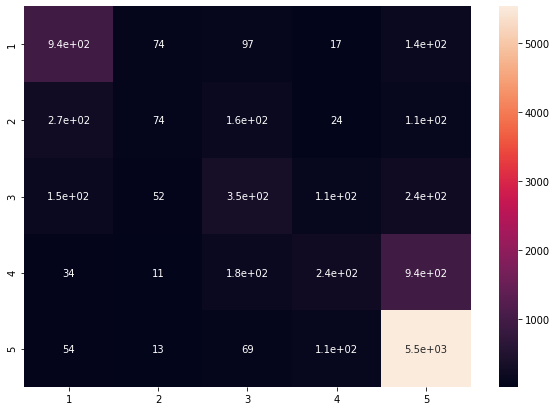

In [30]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
# array = metrics.confusion_matrix(test_ratings, test_predictions)
array = metrics.confusion_matrix(test_ratings, test_predictions)
df_cm = pd.DataFrame(array, index = [i for i in range(1, 6)],
                  columns = [i for i in range(1, 6)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)


### Test input

In [ ]:
# Test input
Test = ['this is bad', 'wow nice!', 'this is a great product']
test_reviews = pd.DataFrame(Test, columns=['reviews'])

# pre-process data
test_reviews, tokenizer = preprocess_data(tokenizer, test_reviews, maxlen=train_reviews.shape[1])

# predict
test_predictions = model.predict(test_reviews)

# show probabilities
print(test_predictions)

### Testing on custom input GUI

In [39]:
import tabulate
def predict_rating(text):
    test_reviews = pd.DataFrame([text], columns=['reviews'])

    test_reviews, _ = preprocess_data(tokenizer, test_reviews, maxlen=maxlen)

    test_predictions = model.predict(test_reviews)
    test_ratings = np.argmax(np.array(test_predictions), axis=1) + 1
    print(tabulate.tabulate(np.round(test_predictions, 3), headers=['Rating-1', 'Rating-2', 'Rating-3', 'Rating-4', 'Rating-5']))
    str = f"\nPredicted Rating: {test_ratings}"
    return str

In [58]:
#@title Predict
InputText = 'wow, the product is horrible' #@param {type: 'string'}
output = predict_rating(InputText)

print(output)


  Rating-1    Rating-2    Rating-3    Rating-4    Rating-5
----------  ----------  ----------  ----------  ----------
     0.883       0.048       0.024       0.006       0.039

Predicted Rating: [1]
